In [1]:
# 적대적 공격의 종류
# 잡음 추가
## 모델 정보를 토대로 잡음을 생성
### 화이트 박스(white box) 방법
### 블랙 박스(black box) 방법
## 원하는 정답으로 유도
### 가능 : 표적(targeted)
### 불가능 : 비표적(non-targeted)
## 학습(최적화)
### 필요 : 반복(iterative)
### 불필요 : 원샷(one-shot)


In [2]:
# FGSM 공격
# fast gradient sign method
# 반복된 학습 없이 잡음을 생성하는 원샷 공격
# 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성
# FGSM은 공격 목표를 정할 수 없는 non-targeted 방식, 대상 모델의 정보가 필요한 화이트박스 방식

In [4]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

model = models.resnet101(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/user/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:31<00:00, 5.74MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

img = Image.open('imagenet_samples/corgie.jpg')

# 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([transforms.Resize((224,224), Image.BICUBIC),
                                    transforms.ToTensor(),])
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print('이미지 텐서 모양:', img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


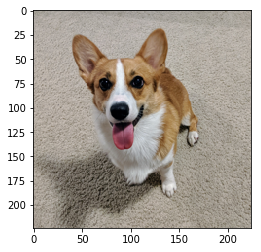

In [8]:
# 시각화를 위해 넘파이 행렬 변환
# [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(original_img_view)

In [9]:
# 학습용 데이터에 없는 이미지를 얼마나 잘 분류하는지 확인
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print('예측된 레이블 번호', prediction_idx)
print('레이블 이름', prediction_name)

예측된 레이블 번호 263
레이블 이름 Pembroke, Pembroke Welsh corgi


In [10]:
# FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본이미지에 더함
# 기울기는 모델이 학습할 때 각 픽셀이 미치는 영향
# 모델을 헷갈리게 하려면 모델의 오차값을 극대화 해야함

# FGSM 공격에선 잡음이 기울기의 방향으로 최적화하도록 해서 오차를 키움
# sign() 함수는 입력이 0보다 작으면 -1, 0보다 크면 1로
# 작은 값인 앱실론(epsilon)을 곱해줌
# 앱실론은 모델 학습 시 지정해줘야 하는 학습률과 같은 개념
# 잡음이 너무 커지지 않고 사람의 눈에 보이지 않게 제한하는 역할

def fgsm_attack(image, epsilon, gradient):
    # 기울깃값의 원소의 sign값을 구함
    sign_gradient = gradient.sign()
    # 이미지의 각 픽셀값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값 조절
    perturbed_iamge = torch.clamp(perturbed_image, 0, 1)
    return perturbed_iamge

In [12]:
# 원본 이미지에 대한 기울기를 추출하려면 requires_grad_(True) 함수를 호출해 이미지에 대한 기울기를 보존하도록 명시
# 그렇지 않으면 기울기가 생성되지 않음

# 이미지의 기울기를 구하도록 설정
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과 시킴
output = model(img_tensor)

# 오차값 구하기(번호 263은 월시코기)
loss = F.nll_loss(output, torch.tensor([263]))

# 기울기 구하기
model.zero_grad()
loss.backward()

In [14]:
# 이미지의 기울기 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03 # 앱실론은 0과 1사이 어느값이라도 괜찮음
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [15]:
# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

In [16]:
# 새로 만들어진 적대적 예제 이미지를 다시 똑같은 모델로 분류
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print('예측된 레이블 번호', perturbed_prediction_idx)
print('레이블 이름', perturbed_prediction_name)

예측된 레이블 번호 172
레이블 이름 whippet


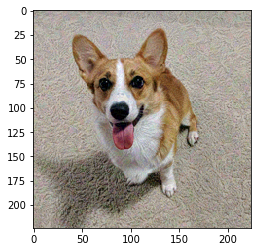

In [17]:
# 시각화를 위해 넘파이 행렬 번환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

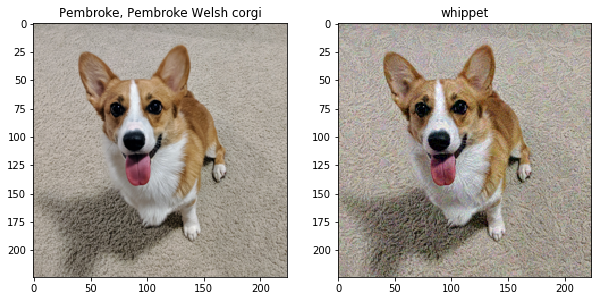

In [18]:
# 원본과 적대적 예제를 나란히 시각화
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)